In [1]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
import shap

In [2]:
# Utiliser le répertoire de travail actuel comme base si __file__ ne fonctionne pas
base_path = Path(os.getcwd())  # Utilisation du répertoire de travail actuel

# Définir le chemin vers le dossier contenant les fichiers zippés
data_path = base_path / '../Data'

# Liste des fichiers à charger
files = {
    'X_train': 'X_train.zip',
    'X_test': 'X_test.zip',
    'y_train': 'y_train.zip',
    'y_test': 'y_test.zip'
}

# Dictionnaire pour stocker les données chargées
data = {}

for key, file_name in files.items():
    file_path = data_path / file_name  # Utilisation de Path pour concaténer le chemin
    try:
        # Charger le fichier CSV compressé en DataFrame
        data[key] = pd.read_csv(file_path, compression='zip')
        print(f"{key} chargé avec succès.")
    except Exception as e:
        print(f"Erreur lors du chargement de {file_name}: {e}")

# Attribution des données aux variables
X_train = data.get('X_train')
X_test = data.get('X_test')
y_train = data.get('y_train')
y_test = data.get('y_test')

# Vérification des dimensions des données
print("\nDimensions des données chargées :")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train chargé avec succès.
X_test chargé avec succès.
y_train chargé avec succès.
y_test chargé avec succès.

Dimensions des données chargées :
X_train: (352893, 337)
X_test: (88224, 337)
y_train: (352893, 1)
y_test: (88224, 1)


In [3]:
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

# Pipeline avec SMOTE suivi de ADASYN
pipeline = Pipeline([
    ('smote', smote),
    ('adasyn', adasyn)
])

# Appliquer le rééchantillonnage
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Convertir y_train_resampled en numpy array et aplatir en 1D
y_train_resampled = y_train_resampled.to_numpy().flatten()

# Vérification de la distribution après rééchantillonnage
print("Distribution des classes après SMOTE et ADASYN :")
print(pd.Series(y_train_resampled).value_counts())

Distribution des classes après SMOTE et ADASYN :
2    145535
0    145535
1    145535
3    145535
Name: count, dtype: int64


In [4]:
from tensorflow.keras.utils import to_categorical

# Conversion des labels en one-hot encoding (si ce n'est pas déjà fait)
y_train_resampled = to_categorical(y_train_resampled, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

In [5]:
# Calcul des poids de classe pour chaque classe
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
# class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))
class_weights_dict = {0: 1, 1: 1, 2: 3, 3: 5}
# Affichage des poids de classe
print("Poids de classe calculés :", class_weights_dict)

Poids de classe calculés : {0: 1, 1: 1, 2: 3, 3: 5}


In [6]:
model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes avec softmax pour multi-classes
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',  # Perte pour multi-classes
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name="precision"),
                       tf.keras.metrics.Recall(name="recall"),
                       tf.keras.metrics.AUC(name="auc")])

In [7]:
# Callback pour un arrêt anticipé
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Callback pour un scheduler du taux d'apprentissage
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = LearningRateScheduler(scheduler)

# Callback pour ajuster dynamiquement le taux d'apprentissage
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Entraînement du modèle avec les callbacks et la fonction de perte dynamique
history = model.fit(
    X_train_resampled, y_train_resampled,  # Utilisation des données équilibrées
    validation_split=0.2,  # Utilisation de 20% des données pour la validation
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler, reduce_lr]
)

Epoch 1/50
14554/14554 [==============================] - 70s 5ms/step - loss: 1.6676 - accuracy: 0.5805 - precision: 0.6276 - recall: 0.4863 - auc: 0.8316 - val_loss: 1.1863 - val_accuracy: 0.2720 - val_precision: 0.2670 - val_recall: 0.2388 - val_auc: 0.7299 - lr: 5.0000e-04
Epoch 2/50
14554/14554 [==============================] - 73s 5ms/step - loss: 1.5599 - accuracy: 0.6069 - precision: 0.6487 - recall: 0.5264 - auc: 0.8518 - val_loss: 1.0461 - val_accuracy: 0.4140 - val_precision: 0.4169 - val_recall: 0.3893 - val_auc: 0.7816 - lr: 5.0000e-04
Epoch 3/50
14554/14554 [==============================] - 90s 6ms/step - loss: 1.5056 - accuracy: 0.6182 - precision: 0.6587 - recall: 0.5435 - auc: 0.8604 - val_loss: 0.8248 - val_accuracy: 0.5759 - val_precision: 0.5897 - val_recall: 0.5525 - val_auc: 0.8632 - lr: 5.0000e-04
Epoch 4/50
14554/14554 [==============================] - 89s 6ms/step - loss: 1.4599 - accuracy: 0.6275 - precision: 0.6674 - recall: 0.5574 - auc: 0.8670 - val_loss

2757/2757 [==============================] - 4s 1ms/step
Matrice de confusion après ajustement du seuil :
 [[27611  4260  4209   184]
 [ 7395 15819 11792   511]
 [  896  1829 10492   775]
 [   96   142  1714   499]]

Rapport de classification après ajustement du seuil :
               precision    recall  f1-score   support

           0       0.77      0.76      0.76     36264
           1       0.72      0.45      0.55     35517
           2       0.37      0.75      0.50     13992
           3       0.25      0.20      0.23      2451

    accuracy                           0.62     88224
   macro avg       0.53      0.54      0.51     88224
weighted avg       0.67      0.62      0.62     88224


Précision : 61.69%


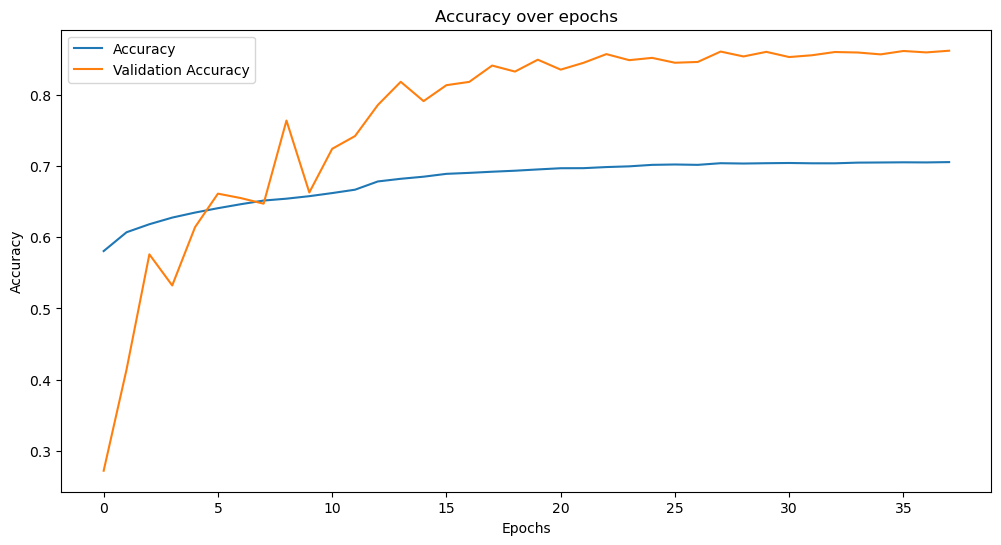

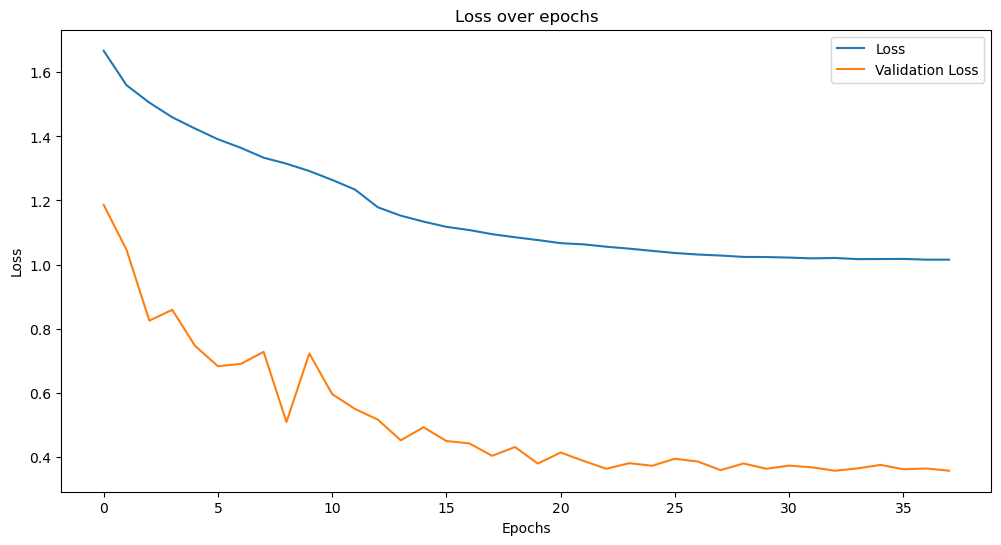

In [8]:
# Prédictions sur les données de test
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Obtenir la classe avec la probabilité la plus élevée

# Ajuster le seuil de classification (par exemple, seuil de 0.4)
threshold = 0.2
y_pred_adjusted = np.argmax((y_pred_probs >= threshold).astype(int) * y_pred_probs, axis=1)

# Affichage des résultats
print("Matrice de confusion après ajustement du seuil :\n", confusion_matrix(y_test, y_pred_adjusted))
print("\nRapport de classification après ajustement du seuil :\n", classification_report(y_test, y_pred_adjusted))
print("\nPrécision : {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
import os
from joblib import dump

# Définir le chemin relatif pour le dossier 'results' dans le répertoire actuel
result_dir = os.path.join(os.getcwd(), "results")

# Chemin complet pour le fichier du modèle
model_path = os.path.join(result_dir, "4class_neural_network_model.joblib")

# Sauvegarde du modèle avec joblib
try:
    dump(model, model_path)
    print(f"Modèle enregistré avec succès dans : {model_path}")
except Exception as e:
    print(f"Erreur lors de l'enregistrement du modèle : {e}")


INFO:tensorflow:Assets written to: ram://0ea3f970-5d2e-4669-af69-b918b9625f3e/assets
Modèle enregistré avec succès dans : C:\Users\Victor\Documents\Projet_accident\neural_network\results\4class_neural_network_model.joblib
